In [1]:
pip install --upgrade torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 36.5 MB/s eta 0:00:00


In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [18]:
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchmetrics import F1Score, Accuracy
import optuna
import matplotlib.pyplot as plt

In [19]:
# Устройство: GPU или CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
device

device(type='cuda')

In [21]:
# Определение модели CNN
class CNN(nn.Module):
    def __init__(self, num_filters, hidden_units):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(num_filters * 2 * 7 * 7, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 10)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # все размеры, кроме размера батча
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [22]:
# Подготовка данных MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [23]:
# Функция обучения и оценки модели
def objective(trial):
    # Гиперпараметры
    num_filters = trial.suggest_int("num_filters", 16, 64)
    hidden_units = trial.suggest_int("hidden_units", 64, 256)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
    num_epochs = trial.suggest_int("num_epochs", 3, 10)  # Увеличено до 10

    # Инициализация модели, критерия и оптимизатора
    model = CNN(num_filters=num_filters, hidden_units=hidden_units).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Обучение модели
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Переносим на GPU
            optimizer.zero_grad()  # Обнуляем градиенты
            outputs = model(images)  # Прямое распространение
            loss = criterion(outputs, labels)  # Вычисляем потерю
            loss.backward()  # Обратное распространение
            optimizer.step()  # Обновляем параметры

        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}')

    # Оценка модели на тестовых данных
    model.eval()
    f1_metric = torchmetrics.F1Score(num_classes=10, average='weighted', task='multiclass').to(device)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Переносим на GPU
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            f1_metric.update(preds, labels)

    f1 = f1_metric.compute()
    f1_metric.reset()

    # Сохраняем значения для графиков
    num_filters_list.append(num_filters)
    hidden_units_list.append(hidden_units)
    f1_scores.append(f1.item())

    return f1.item()  # Возвращаем F1

In [24]:
# Функция обучения и оценки модели
def objective1(trial):
    # Гиперпараметры
    num_filters = trial.suggest_int("num_filters", 16, 64)
    hidden_units = trial.suggest_int("hidden_units", 64, 256)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
    num_epochs = trial.suggest_int("num_epochs", 3, 10)  # Увеличено до 10

    # Инициализация модели, критерия и оптимизатора
    model = CNN(num_filters=num_filters, hidden_units=hidden_units).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Обучение модели
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Переносим на GPU
            optimizer.zero_grad()  # Обнуляем градиенты
            outputs = model(images)  # Прямое распространение
            loss = criterion(outputs, labels)  # Вычисляем потерю
            loss.backward()  # Обратное распространение
            optimizer.step()  # Обновляем параметры

        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}')

    # Оценка модели на тестовых данных
    model.eval()
    accuracy_metric = torchmetrics.Accuracy(num_classes=10, average='weighted', task='multiclass').to(device)

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}')

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            accuracy_metric.update(preds, labels)

    accuracy = accuracy_metric.compute()
    accuracy_metric.reset()

    # Сохраняем значения для графиков
    num_filters_list.append(num_filters)
    hidden_units_list.append(hidden_units)
    accuracy_list.append(accuracy.item())

    return accuracy.item()  # Возвращаем точность

[I 2024-11-18 21:16:48,386] A new study created in memory with name: no-name-b816b39f-d7ed-4208-94d7-85356b3774a4
<ipython-input-23-6d8b412f7809>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)


Epoch 1/7, Training Loss: 0.22670957446098328
Epoch 2/7, Training Loss: 0.06385567039251328
Epoch 3/7, Training Loss: 0.1363244205713272
Epoch 4/7, Training Loss: 0.22149965167045593
Epoch 5/7, Training Loss: 0.05626334249973297
Epoch 6/7, Training Loss: 0.03924139216542244
Epoch 7/7, Training Loss: 0.15614354610443115


[I 2024-11-18 21:18:41,740] Trial 0 finished with value: 0.9787882566452026 and parameters: {'num_filters': 44, 'hidden_units': 245, 'learning_rate': 1.6778550147600985e-05, 'num_epochs': 7}. Best is trial 0 with value: 0.9787882566452026.


Epoch 1/3, Training Loss: 0.014845447614789009
Epoch 2/3, Training Loss: 0.1427973508834839
Epoch 3/3, Training Loss: 0.2849772572517395


[I 2024-11-18 21:19:31,780] Trial 1 finished with value: 0.9631644487380981 and parameters: {'num_filters': 37, 'hidden_units': 134, 'learning_rate': 0.011916804130341394, 'num_epochs': 3}. Best is trial 0 with value: 0.9787882566452026.


Epoch 1/5, Training Loss: 0.012547966092824936
Epoch 2/5, Training Loss: 0.09661798179149628
Epoch 3/5, Training Loss: 0.006920664105564356
Epoch 4/5, Training Loss: 0.1522386223077774
Epoch 5/5, Training Loss: 0.02247626706957817


[I 2024-11-18 21:20:53,180] Trial 2 finished with value: 0.9844927787780762 and parameters: {'num_filters': 39, 'hidden_units': 135, 'learning_rate': 0.00392818823925163, 'num_epochs': 5}. Best is trial 2 with value: 0.9844927787780762.


Epoch 1/9, Training Loss: 2.3049066066741943
Epoch 2/9, Training Loss: 2.3092665672302246
Epoch 3/9, Training Loss: 2.2983250617980957
Epoch 4/9, Training Loss: 2.277865409851074
Epoch 5/9, Training Loss: 2.329288959503174
Epoch 6/9, Training Loss: 2.3064324855804443
Epoch 7/9, Training Loss: 2.294422149658203
Epoch 8/9, Training Loss: 2.29235577583313
Epoch 9/9, Training Loss: 2.343329906463623


[I 2024-11-18 21:23:18,025] Trial 3 finished with value: 0.01916547119617462 and parameters: {'num_filters': 37, 'hidden_units': 165, 'learning_rate': 0.03527718164318279, 'num_epochs': 9}. Best is trial 2 with value: 0.9844927787780762.


Epoch 1/6, Training Loss: 0.06765468418598175
Epoch 2/6, Training Loss: 0.08393383026123047
Epoch 3/6, Training Loss: 0.010827833786606789
Epoch 4/6, Training Loss: 0.05453953146934509
Epoch 5/6, Training Loss: 0.0263067539781332
Epoch 6/6, Training Loss: 0.0010390649549663067


[I 2024-11-18 21:24:54,763] Trial 4 finished with value: 0.9896942973136902 and parameters: {'num_filters': 58, 'hidden_units': 117, 'learning_rate': 0.00016033912444849815, 'num_epochs': 6}. Best is trial 4 with value: 0.9896942973136902.


Epoch 1/3, Training Loss: 2.299506425857544
Epoch 2/3, Training Loss: 2.3028078079223633
Epoch 3/3, Training Loss: 2.3011562824249268


[I 2024-11-18 21:25:44,346] Trial 5 finished with value: 0.02313830330967903 and parameters: {'num_filters': 34, 'hidden_units': 226, 'learning_rate': 0.016063366125388147, 'num_epochs': 3}. Best is trial 4 with value: 0.9896942973136902.


Epoch 1/9, Training Loss: 0.06335832178592682
Epoch 2/9, Training Loss: 0.10758504271507263
Epoch 3/9, Training Loss: 0.05564721301198006
Epoch 4/9, Training Loss: 0.026718994602560997
Epoch 5/9, Training Loss: 0.03579026088118553
Epoch 6/9, Training Loss: 0.01828341744840145
Epoch 7/9, Training Loss: 0.21108125150203705
Epoch 8/9, Training Loss: 0.0014393535675480962
Epoch 9/9, Training Loss: 0.13835255801677704


[I 2024-11-18 21:28:08,342] Trial 6 finished with value: 0.9701352715492249 and parameters: {'num_filters': 59, 'hidden_units': 130, 'learning_rate': 0.005021099672261795, 'num_epochs': 9}. Best is trial 4 with value: 0.9896942973136902.


Epoch 1/10, Training Loss: 0.27149084210395813
Epoch 2/10, Training Loss: 0.16800235211849213
Epoch 3/10, Training Loss: 0.05120770260691643
Epoch 4/10, Training Loss: 0.04207378625869751
Epoch 5/10, Training Loss: 0.23093686997890472
Epoch 6/10, Training Loss: 0.06252531707286835
Epoch 7/10, Training Loss: 0.1553567796945572
Epoch 8/10, Training Loss: 0.0506526455283165
Epoch 9/10, Training Loss: 0.044779837131500244
Epoch 10/10, Training Loss: 0.030891647562384605


[I 2024-11-18 21:30:48,617] Trial 7 finished with value: 0.9791836738586426 and parameters: {'num_filters': 20, 'hidden_units': 109, 'learning_rate': 2.423912705508329e-05, 'num_epochs': 10}. Best is trial 4 with value: 0.9896942973136902.


Epoch 1/10, Training Loss: 0.020141590386629105
Epoch 2/10, Training Loss: 0.002045127097517252
Epoch 3/10, Training Loss: 0.00346996053121984
Epoch 4/10, Training Loss: 0.00023279910965356976
Epoch 5/10, Training Loss: 0.002930588088929653
Epoch 6/10, Training Loss: 0.0037885073106735945
Epoch 7/10, Training Loss: 0.00916951335966587
Epoch 8/10, Training Loss: 0.000896835932508111
Epoch 9/10, Training Loss: 7.573622860945761e-05
Epoch 10/10, Training Loss: 0.022666864097118378


[I 2024-11-18 21:33:26,301] Trial 8 finished with value: 0.9877009391784668 and parameters: {'num_filters': 51, 'hidden_units': 97, 'learning_rate': 0.0025112006084304747, 'num_epochs': 10}. Best is trial 4 with value: 0.9896942973136902.


Epoch 1/4, Training Loss: 0.05456883832812309
Epoch 2/4, Training Loss: 0.003072927473112941
Epoch 3/4, Training Loss: 0.00043694357736967504
Epoch 4/4, Training Loss: 8.986252214526758e-05


[I 2024-11-18 21:34:32,008] Trial 9 finished with value: 0.9901927709579468 and parameters: {'num_filters': 60, 'hidden_units': 84, 'learning_rate': 0.0024787644105059748, 'num_epochs': 4}. Best is trial 9 with value: 0.9901927709579468.


Epoch 1/5, Training Loss: 0.026039354503154755
Epoch 2/5, Training Loss: 0.0600617378950119
Epoch 3/5, Training Loss: 0.021831318736076355
Epoch 4/5, Training Loss: 0.0007736760308034718
Epoch 5/5, Training Loss: 0.12767906486988068


[I 2024-11-18 21:35:51,918] Trial 10 finished with value: 0.9882030487060547 and parameters: {'num_filters': 25, 'hidden_units': 64, 'learning_rate': 0.00033789232976846, 'num_epochs': 5}. Best is trial 9 with value: 0.9901927709579468.


Epoch 1/6, Training Loss: 0.026915766298770905
Epoch 2/6, Training Loss: 0.04393914341926575
Epoch 3/6, Training Loss: 0.01190892606973648
Epoch 4/6, Training Loss: 0.10187410563230515
Epoch 5/6, Training Loss: 0.019329864531755447
Epoch 6/6, Training Loss: 0.010409574955701828


[I 2024-11-18 21:37:28,847] Trial 11 finished with value: 0.9895991086959839 and parameters: {'num_filters': 64, 'hidden_units': 77, 'learning_rate': 0.00027873822695608744, 'num_epochs': 6}. Best is trial 9 with value: 0.9901927709579468.


Epoch 1/4, Training Loss: 0.10525082051753998
Epoch 2/4, Training Loss: 0.018905341625213623
Epoch 3/4, Training Loss: 0.0015843918081372976
Epoch 4/4, Training Loss: 0.0011791256256401539


[I 2024-11-18 21:38:35,559] Trial 12 finished with value: 0.9885983467102051 and parameters: {'num_filters': 53, 'hidden_units': 191, 'learning_rate': 0.0007342787414127587, 'num_epochs': 4}. Best is trial 9 with value: 0.9901927709579468.


Epoch 1/7, Training Loss: 0.12424948811531067
Epoch 2/7, Training Loss: 0.0953640341758728
Epoch 3/7, Training Loss: 0.02363651618361473
Epoch 4/7, Training Loss: 0.0017504700226709247
Epoch 5/7, Training Loss: 0.011097336187958717
Epoch 6/7, Training Loss: 0.050361987203359604
Epoch 7/7, Training Loss: 0.004120722413063049


[I 2024-11-18 21:40:26,917] Trial 13 finished with value: 0.9875987768173218 and parameters: {'num_filters': 54, 'hidden_units': 97, 'learning_rate': 7.677386666162409e-05, 'num_epochs': 7}. Best is trial 9 with value: 0.9901927709579468.


Epoch 1/5, Training Loss: 0.04447351396083832
Epoch 2/5, Training Loss: 0.003443610854446888
Epoch 3/5, Training Loss: 0.0014379103668034077
Epoch 4/5, Training Loss: 0.061461981385946274
Epoch 5/5, Training Loss: 0.003150442847982049


[I 2024-11-18 21:41:46,616] Trial 14 finished with value: 0.989694356918335 and parameters: {'num_filters': 64, 'hidden_units': 164, 'learning_rate': 0.00014047046643465505, 'num_epochs': 5}. Best is trial 9 with value: 0.9901927709579468.


Epoch 1/4, Training Loss: 0.19053901731967926
Epoch 2/4, Training Loss: 0.04728522524237633
Epoch 3/4, Training Loss: 0.00025080007617361844
Epoch 4/4, Training Loss: 0.0010449286783114076


[I 2024-11-18 21:42:50,510] Trial 15 finished with value: 0.9917033910751343 and parameters: {'num_filters': 64, 'hidden_units': 176, 'learning_rate': 0.0013654604765888966, 'num_epochs': 4}. Best is trial 15 with value: 0.9917033910751343.


Epoch 1/4, Training Loss: 2.298868179321289
Epoch 2/4, Training Loss: 2.2938342094421387
Epoch 3/4, Training Loss: 2.3549890518188477
Epoch 4/4, Training Loss: 2.318939447402954


[I 2024-11-18 21:43:54,285] Trial 16 finished with value: 0.01916547119617462 and parameters: {'num_filters': 47, 'hidden_units': 193, 'learning_rate': 0.09552832671503553, 'num_epochs': 4}. Best is trial 15 with value: 0.9917033910751343.


Epoch 1/4, Training Loss: 0.14849083125591278
Epoch 2/4, Training Loss: 0.002713915193453431
Epoch 3/4, Training Loss: 0.12837067246437073
Epoch 4/4, Training Loss: 0.00026230994262732565


[I 2024-11-18 21:44:57,699] Trial 17 finished with value: 0.9902934432029724 and parameters: {'num_filters': 59, 'hidden_units': 198, 'learning_rate': 0.002248613670517812, 'num_epochs': 4}. Best is trial 15 with value: 0.9917033910751343.


Epoch 1/3, Training Loss: 0.062545046210289
Epoch 2/3, Training Loss: 0.01350616104900837
Epoch 3/3, Training Loss: 0.000651781156193465


[I 2024-11-18 21:45:46,163] Trial 18 finished with value: 0.9895085096359253 and parameters: {'num_filters': 50, 'hidden_units': 197, 'learning_rate': 0.001104212188105948, 'num_epochs': 3}. Best is trial 15 with value: 0.9917033910751343.


Epoch 1/8, Training Loss: 0.15503208339214325
Epoch 2/8, Training Loss: 0.002099162433296442
Epoch 3/8, Training Loss: 0.05778666213154793
Epoch 4/8, Training Loss: 0.1304793357849121
Epoch 5/8, Training Loss: 0.03103335201740265
Epoch 6/8, Training Loss: 1.3071077773929574e-05
Epoch 7/8, Training Loss: 0.0006657529156655073
Epoch 8/8, Training Loss: 0.0003665276453830302


[I 2024-11-18 21:47:51,427] Trial 19 finished with value: 0.9915974736213684 and parameters: {'num_filters': 31, 'hidden_units': 218, 'learning_rate': 0.0007118330105397622, 'num_epochs': 8}. Best is trial 15 with value: 0.9917033910751343.


Epoch 1/8, Training Loss: 0.07132192701101303
Epoch 2/8, Training Loss: 0.00481803435832262
Epoch 3/8, Training Loss: 0.0002890006871894002
Epoch 4/8, Training Loss: 0.01222321018576622
Epoch 5/8, Training Loss: 0.005980756599456072
Epoch 6/8, Training Loss: 0.0003341102856211364
Epoch 7/8, Training Loss: 1.0825197932717856e-05
Epoch 8/8, Training Loss: 0.0008060414111241698


[I 2024-11-18 21:49:56,572] Trial 20 finished with value: 0.9912989735603333 and parameters: {'num_filters': 30, 'hidden_units': 225, 'learning_rate': 0.0006538769417430517, 'num_epochs': 8}. Best is trial 15 with value: 0.9917033910751343.


Epoch 1/8, Training Loss: 0.14579463005065918
Epoch 2/8, Training Loss: 0.005477932747453451
Epoch 3/8, Training Loss: 0.008997289463877678
Epoch 4/8, Training Loss: 0.0016012981068342924
Epoch 5/8, Training Loss: 0.0011885752901434898
Epoch 6/8, Training Loss: 0.07507455348968506
Epoch 7/8, Training Loss: 0.010610084049403667
Epoch 8/8, Training Loss: 9.274239710066468e-05


[I 2024-11-18 21:52:00,064] Trial 21 finished with value: 0.9917988181114197 and parameters: {'num_filters': 30, 'hidden_units': 228, 'learning_rate': 0.0006753807851413122, 'num_epochs': 8}. Best is trial 21 with value: 0.9917988181114197.


Epoch 1/8, Training Loss: 0.01901085488498211
Epoch 2/8, Training Loss: 0.13225317001342773
Epoch 3/8, Training Loss: 0.002051924355328083
Epoch 4/8, Training Loss: 0.0016120512736961246
Epoch 5/8, Training Loss: 0.0006218759226612747
Epoch 6/8, Training Loss: 0.00010169544111704454
Epoch 7/8, Training Loss: 7.00352472904342e-07
Epoch 8/8, Training Loss: 0.00028569746064022183


[I 2024-11-18 21:54:03,956] Trial 22 finished with value: 0.9912002086639404 and parameters: {'num_filters': 29, 'hidden_units': 255, 'learning_rate': 0.0010814943317953884, 'num_epochs': 8}. Best is trial 21 with value: 0.9917988181114197.


Epoch 1/8, Training Loss: 0.05191554129123688
Epoch 2/8, Training Loss: 0.05614905431866646
Epoch 3/8, Training Loss: 0.06808383017778397
Epoch 4/8, Training Loss: 0.017411844804883003
Epoch 5/8, Training Loss: 0.030341094359755516
Epoch 6/8, Training Loss: 0.021306456997990608
Epoch 7/8, Training Loss: 0.03003527596592903
Epoch 8/8, Training Loss: 0.007027585059404373


[I 2024-11-18 21:56:07,404] Trial 23 finished with value: 0.985693097114563 and parameters: {'num_filters': 22, 'hidden_units': 219, 'learning_rate': 5.6672342811724194e-05, 'num_epochs': 8}. Best is trial 21 with value: 0.9917988181114197.


Epoch 1/9, Training Loss: 0.21422173082828522
Epoch 2/9, Training Loss: 0.008518592454493046
Epoch 3/9, Training Loss: 0.015751482918858528
Epoch 4/9, Training Loss: 0.04356793314218521
Epoch 5/9, Training Loss: 0.007088343147188425
Epoch 6/9, Training Loss: 0.006926540285348892
Epoch 7/9, Training Loss: 0.0007598597439937294
Epoch 8/9, Training Loss: 0.000116368530143518
Epoch 9/9, Training Loss: 0.00040130451088771224


[I 2024-11-18 21:58:21,566] Trial 24 finished with value: 0.9906991720199585 and parameters: {'num_filters': 17, 'hidden_units': 177, 'learning_rate': 0.00037738390291851097, 'num_epochs': 9}. Best is trial 21 with value: 0.9917988181114197.


Epoch 1/7, Training Loss: 2.3169612884521484
Epoch 2/7, Training Loss: 2.3040804862976074
Epoch 3/7, Training Loss: 2.2737579345703125
Epoch 4/7, Training Loss: 2.3189754486083984
Epoch 5/7, Training Loss: 2.3136675357818604
Epoch 6/7, Training Loss: 2.296410083770752
Epoch 7/7, Training Loss: 2.2977890968322754


[I 2024-11-18 22:00:05,676] Trial 25 finished with value: 0.02313830330967903 and parameters: {'num_filters': 29, 'hidden_units': 214, 'learning_rate': 0.00736295787444286, 'num_epochs': 7}. Best is trial 21 with value: 0.9917988181114197.


Epoch 1/8, Training Loss: 0.005500681232661009
Epoch 2/8, Training Loss: 0.012522159144282341
Epoch 3/8, Training Loss: 0.00039559160359203815
Epoch 4/8, Training Loss: 0.0014525128062814474
Epoch 5/8, Training Loss: 0.00023841804068069905
Epoch 6/8, Training Loss: 0.056376803666353226
Epoch 7/8, Training Loss: 0.0033449067268520594
Epoch 8/8, Training Loss: 0.00017517943342681974


[I 2024-11-18 22:02:05,012] Trial 26 finished with value: 0.9911953210830688 and parameters: {'num_filters': 42, 'hidden_units': 239, 'learning_rate': 0.0014565578019792495, 'num_epochs': 8}. Best is trial 21 with value: 0.9917988181114197.


Epoch 1/6, Training Loss: 0.09231962263584137
Epoch 2/6, Training Loss: 0.021721091121435165
Epoch 3/6, Training Loss: 0.0017046219436451793
Epoch 4/6, Training Loss: 0.041114699095487595
Epoch 5/6, Training Loss: 0.002028017770498991
Epoch 6/6, Training Loss: 0.09583189338445663


[I 2024-11-18 22:03:34,927] Trial 27 finished with value: 0.9901994466781616 and parameters: {'num_filters': 33, 'hidden_units': 209, 'learning_rate': 0.00017595750810713124, 'num_epochs': 6}. Best is trial 21 with value: 0.9917988181114197.


Epoch 1/9, Training Loss: 0.11039772629737854
Epoch 2/9, Training Loss: 0.015351557172834873
Epoch 3/9, Training Loss: 0.03784988820552826
Epoch 4/9, Training Loss: 0.277245432138443
Epoch 5/9, Training Loss: 0.007930914871394634
Epoch 6/9, Training Loss: 0.0001925429969560355
Epoch 7/9, Training Loss: 0.00042611616663634777
Epoch 8/9, Training Loss: 3.1961986678652465e-05
Epoch 9/9, Training Loss: 0.00146616215351969


[I 2024-11-18 22:05:48,922] Trial 28 finished with value: 0.9923017024993896 and parameters: {'num_filters': 26, 'hidden_units': 152, 'learning_rate': 0.0005446003601459186, 'num_epochs': 9}. Best is trial 28 with value: 0.9923017024993896.


Epoch 1/7, Training Loss: 0.3155488967895508
Epoch 2/7, Training Loss: 0.21678151190280914
Epoch 3/7, Training Loss: 0.0444718673825264
Epoch 4/7, Training Loss: 0.05559990555047989
Epoch 5/7, Training Loss: 0.01964631676673889
Epoch 6/7, Training Loss: 0.013568809255957603
Epoch 7/7, Training Loss: 0.08024448156356812


[I 2024-11-18 22:07:33,324] Trial 29 finished with value: 0.9823911190032959 and parameters: {'num_filters': 26, 'hidden_units': 151, 'learning_rate': 3.731010722829005e-05, 'num_epochs': 7}. Best is trial 28 with value: 0.9923017024993896.


Best trial:
  F1 Score: 0.9923017024993896
  Params: 
    num_filters: 26
    hidden_units: 152
    learning_rate: 0.0005446003601459186
    num_epochs: 9


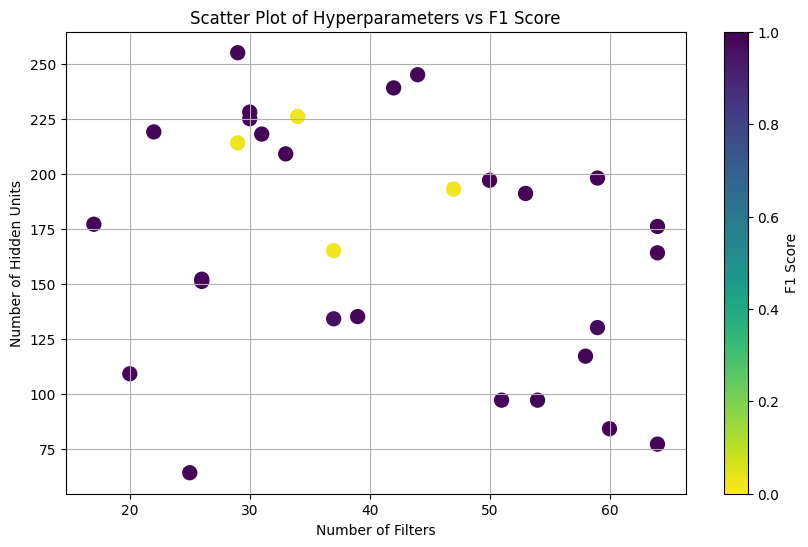

[I 2024-11-18 22:07:33,587] A new study created in memory with name: no-name-edb1d085-1d6c-4574-bd62-f9e1655f3650


Epoch 1/7, Training Loss: 0.04112078249454498
Epoch 2/7, Training Loss: 0.017074815928936005
Epoch 3/7, Training Loss: 0.010698769241571426
Epoch 4/7, Training Loss: 0.017110025510191917
Epoch 5/7, Training Loss: 0.0007432561251334846
Epoch 6/7, Training Loss: 0.0020331135019659996
Epoch 7/7, Training Loss: 0.06395173072814941
Epoch 1/7, Training Loss: 0.02643316052854061
Epoch 2/7, Training Loss: 0.005225431639701128
Epoch 3/7, Training Loss: 0.0008818845963105559
Epoch 4/7, Training Loss: 0.00016936803876888007
Epoch 5/7, Training Loss: 0.0019388283835723996
Epoch 6/7, Training Loss: 0.08012338727712631
Epoch 7/7, Training Loss: 8.401359082199633e-05


[I 2024-11-18 22:10:59,891] Trial 0 finished with value: 0.9907999634742737 and parameters: {'num_filters': 27, 'hidden_units': 203, 'learning_rate': 0.0003344939065681287, 'num_epochs': 7}. Best is trial 0 with value: 0.9907999634742737.


Epoch 1/8, Training Loss: 2.2976083755493164
Epoch 2/8, Training Loss: 2.311053514480591
Epoch 3/8, Training Loss: 2.298666477203369
Epoch 4/8, Training Loss: 2.3060038089752197
Epoch 5/8, Training Loss: 2.323367118835449
Epoch 6/8, Training Loss: 2.342897891998291
Epoch 7/8, Training Loss: 2.3007781505584717
Epoch 8/8, Training Loss: 2.2989938259124756
Epoch 1/8, Training Loss: 2.3102917671203613
Epoch 2/8, Training Loss: 2.346651554107666
Epoch 3/8, Training Loss: 2.3035435676574707
Epoch 4/8, Training Loss: 2.3013453483581543
Epoch 5/8, Training Loss: 2.346799373626709
Epoch 6/8, Training Loss: 2.272861957550049
Epoch 7/8, Training Loss: 2.3021912574768066
Epoch 8/8, Training Loss: 2.340445041656494


[I 2024-11-18 22:14:59,159] Trial 1 finished with value: 0.10320000350475311 and parameters: {'num_filters': 41, 'hidden_units': 132, 'learning_rate': 0.04558013512512055, 'num_epochs': 8}. Best is trial 0 with value: 0.9907999634742737.


Epoch 1/8, Training Loss: 0.08915573358535767
Epoch 2/8, Training Loss: 0.009854761883616447
Epoch 3/8, Training Loss: 0.0020795532036572695
Epoch 4/8, Training Loss: 0.10882008075714111
Epoch 5/8, Training Loss: 0.012325863353908062
Epoch 6/8, Training Loss: 0.12152832746505737
Epoch 7/8, Training Loss: 0.01370923686772585
Epoch 8/8, Training Loss: 0.0077536944299936295
Epoch 1/8, Training Loss: 0.02286449261009693
Epoch 2/8, Training Loss: 0.09918167442083359
Epoch 3/8, Training Loss: 0.002408468397334218
Epoch 4/8, Training Loss: 0.02076186053454876
Epoch 5/8, Training Loss: 0.014885611832141876
Epoch 6/8, Training Loss: 0.2011043280363083
Epoch 7/8, Training Loss: 0.0004960913793183863
Epoch 8/8, Training Loss: 0.05752116069197655


[I 2024-11-18 22:19:02,031] Trial 2 finished with value: 0.963100016117096 and parameters: {'num_filters': 61, 'hidden_units': 248, 'learning_rate': 0.015824518349453767, 'num_epochs': 8}. Best is trial 0 with value: 0.9907999634742737.


Epoch 1/3, Training Loss: 0.19801558554172516
Epoch 2/3, Training Loss: 0.00586618110537529
Epoch 3/3, Training Loss: 0.03125746175646782
Epoch 1/3, Training Loss: 0.004483443684875965
Epoch 2/3, Training Loss: 0.015086885541677475
Epoch 3/3, Training Loss: 0.11921146512031555


[I 2024-11-18 22:20:32,740] Trial 3 finished with value: 0.9851999878883362 and parameters: {'num_filters': 46, 'hidden_units': 86, 'learning_rate': 0.0041588784304794615, 'num_epochs': 3}. Best is trial 0 with value: 0.9907999634742737.


Epoch 1/5, Training Loss: 0.08864648640155792
Epoch 2/5, Training Loss: 0.15085449814796448
Epoch 3/5, Training Loss: 0.22426575422286987
Epoch 4/5, Training Loss: 0.007805521599948406
Epoch 5/5, Training Loss: 0.08018836379051208
Epoch 1/5, Training Loss: 0.05930346995592117
Epoch 2/5, Training Loss: 0.010941596701741219
Epoch 3/5, Training Loss: 0.01577039249241352
Epoch 4/5, Training Loss: 0.007847720757126808
Epoch 5/5, Training Loss: 0.00927433930337429


[I 2024-11-18 22:23:01,185] Trial 4 finished with value: 0.9872999787330627 and parameters: {'num_filters': 35, 'hidden_units': 148, 'learning_rate': 5.4100830349742104e-05, 'num_epochs': 5}. Best is trial 0 with value: 0.9907999634742737.


Epoch 1/8, Training Loss: 0.04590820521116257
Epoch 2/8, Training Loss: 0.0401785671710968
Epoch 3/8, Training Loss: 0.0035349950194358826
Epoch 4/8, Training Loss: 0.02518666721880436
Epoch 5/8, Training Loss: 0.003672368125990033
Epoch 6/8, Training Loss: 0.009493542835116386
Epoch 7/8, Training Loss: 0.06430544704198837
Epoch 8/8, Training Loss: 0.002604064531624317
Epoch 1/8, Training Loss: 0.0013664774596691132
Epoch 2/8, Training Loss: 0.0006544310017488897
Epoch 3/8, Training Loss: 0.013425402343273163
Epoch 4/8, Training Loss: 0.005335589870810509
Epoch 5/8, Training Loss: 0.0008902745321393013
Epoch 6/8, Training Loss: 0.04805394262075424
Epoch 7/8, Training Loss: 0.001538793439976871
Epoch 8/8, Training Loss: 0.0012488231295719743


[I 2024-11-18 22:27:00,997] Trial 5 finished with value: 0.991100013256073 and parameters: {'num_filters': 57, 'hidden_units': 74, 'learning_rate': 0.00010391230679288197, 'num_epochs': 8}. Best is trial 5 with value: 0.991100013256073.


Epoch 1/7, Training Loss: 2.3134407997131348
Epoch 2/7, Training Loss: 2.3001182079315186
Epoch 3/7, Training Loss: 2.301673650741577
Epoch 4/7, Training Loss: 2.2924444675445557
Epoch 5/7, Training Loss: 2.3217244148254395
Epoch 6/7, Training Loss: 2.294595956802368
Epoch 7/7, Training Loss: 2.3150172233581543
Epoch 1/7, Training Loss: 2.304537296295166
Epoch 2/7, Training Loss: 2.293821334838867
Epoch 3/7, Training Loss: 2.310939311981201
Epoch 4/7, Training Loss: 2.289669990539551
Epoch 5/7, Training Loss: 2.2978763580322266
Epoch 6/7, Training Loss: 2.2906856536865234
Epoch 7/7, Training Loss: 2.3012959957122803


[I 2024-11-18 22:30:35,246] Trial 6 finished with value: 0.11349999904632568 and parameters: {'num_filters': 47, 'hidden_units': 72, 'learning_rate': 0.009226767866931267, 'num_epochs': 7}. Best is trial 5 with value: 0.991100013256073.


Epoch 1/10, Training Loss: 2.2922589778900146
Epoch 2/10, Training Loss: 2.288553237915039
Epoch 3/10, Training Loss: 2.2941431999206543
Epoch 4/10, Training Loss: 2.33413028717041
Epoch 5/10, Training Loss: 2.308467388153076
Epoch 6/10, Training Loss: 2.276594638824463
Epoch 7/10, Training Loss: 2.298830032348633
Epoch 8/10, Training Loss: 2.2934956550598145
Epoch 9/10, Training Loss: 2.2951855659484863
Epoch 10/10, Training Loss: 2.3142943382263184
Epoch 1/10, Training Loss: 2.288137674331665
Epoch 2/10, Training Loss: 2.310877561569214
Epoch 3/10, Training Loss: 2.2963168621063232
Epoch 4/10, Training Loss: 2.30619478225708
Epoch 5/10, Training Loss: 2.29304575920105
Epoch 6/10, Training Loss: 2.3015527725219727
Epoch 7/10, Training Loss: 2.3115973472595215
Epoch 8/10, Training Loss: 2.284379005432129
Epoch 9/10, Training Loss: 2.3128223419189453
Epoch 10/10, Training Loss: 2.295870304107666


[I 2024-11-18 22:35:38,541] Trial 7 finished with value: 0.10100000351667404 and parameters: {'num_filters': 49, 'hidden_units': 146, 'learning_rate': 0.03663597201030711, 'num_epochs': 10}. Best is trial 5 with value: 0.991100013256073.


Epoch 1/5, Training Loss: 2.316481351852417
Epoch 2/5, Training Loss: 2.3191397190093994
Epoch 3/5, Training Loss: 2.280158281326294
Epoch 4/5, Training Loss: 2.313593864440918
Epoch 5/5, Training Loss: 2.323589324951172
Epoch 1/5, Training Loss: 2.3062703609466553
Epoch 2/5, Training Loss: 2.3159430027008057
Epoch 3/5, Training Loss: 2.309314727783203
Epoch 4/5, Training Loss: 2.313042163848877
Epoch 5/5, Training Loss: 2.318589210510254


[I 2024-11-18 22:38:10,970] Trial 8 finished with value: 0.11349999904632568 and parameters: {'num_filters': 20, 'hidden_units': 85, 'learning_rate': 0.05135004505406441, 'num_epochs': 5}. Best is trial 5 with value: 0.991100013256073.


Epoch 1/4, Training Loss: 0.02583395503461361
Epoch 2/4, Training Loss: 0.0013568098656833172
Epoch 3/4, Training Loss: 0.004666154272854328
Epoch 4/4, Training Loss: 0.0008878296939656138
Epoch 1/4, Training Loss: 0.10999876260757446
Epoch 2/4, Training Loss: 0.00035322009352967143
Epoch 3/4, Training Loss: 0.006032023578882217
Epoch 4/4, Training Loss: 0.004771315027028322


[I 2024-11-18 22:40:15,001] Trial 9 finished with value: 0.9912999868392944 and parameters: {'num_filters': 38, 'hidden_units': 69, 'learning_rate': 0.0008398029251145502, 'num_epochs': 4}. Best is trial 9 with value: 0.9912999868392944.


Epoch 1/3, Training Loss: 0.05701697990298271
Epoch 2/3, Training Loss: 0.03278735652565956
Epoch 3/3, Training Loss: 0.08135986328125
Epoch 1/3, Training Loss: 0.004296534229069948
Epoch 2/3, Training Loss: 0.011069418862462044
Epoch 3/3, Training Loss: 0.043507713824510574


[I 2024-11-18 22:41:50,446] Trial 10 finished with value: 0.9908000230789185 and parameters: {'num_filters': 32, 'hidden_units': 195, 'learning_rate': 0.000995394863587699, 'num_epochs': 3}. Best is trial 9 with value: 0.9912999868392944.


Epoch 1/10, Training Loss: 0.14658614993095398
Epoch 2/10, Training Loss: 0.3432871699333191
Epoch 3/10, Training Loss: 0.1446157693862915
Epoch 4/10, Training Loss: 0.06489556282758713
Epoch 5/10, Training Loss: 0.18865692615509033
Epoch 6/10, Training Loss: 0.01051533967256546
Epoch 7/10, Training Loss: 0.09596090763807297
Epoch 8/10, Training Loss: 0.12685264647006989
Epoch 9/10, Training Loss: 0.0428335964679718
Epoch 10/10, Training Loss: 0.04413941130042076
Epoch 1/10, Training Loss: 0.045598991215229034
Epoch 2/10, Training Loss: 0.08003529161214828
Epoch 3/10, Training Loss: 0.024264918640255928
Epoch 4/10, Training Loss: 0.03693322092294693
Epoch 5/10, Training Loss: 0.0078786201775074
Epoch 6/10, Training Loss: 0.04320146143436432
Epoch 7/10, Training Loss: 0.035375259816646576
Epoch 8/10, Training Loss: 0.02971065230667591
Epoch 9/10, Training Loss: 0.15577803552150726
Epoch 10/10, Training Loss: 0.015477544628083706


[I 2024-11-18 22:47:03,136] Trial 11 finished with value: 0.9871000051498413 and parameters: {'num_filters': 59, 'hidden_units': 110, 'learning_rate': 1.722332991572285e-05, 'num_epochs': 10}. Best is trial 9 with value: 0.9912999868392944.


Epoch 1/5, Training Loss: 0.12329918891191483
Epoch 2/5, Training Loss: 0.01897103525698185
Epoch 3/5, Training Loss: 0.011425873264670372
Epoch 4/5, Training Loss: 0.007587334606796503
Epoch 5/5, Training Loss: 0.002836971776559949
Epoch 1/5, Training Loss: 0.03612399846315384
Epoch 2/5, Training Loss: 0.005491106770932674
Epoch 3/5, Training Loss: 0.002374829724431038
Epoch 4/5, Training Loss: 0.03141193836927414
Epoch 5/5, Training Loss: 0.10614258050918579


[I 2024-11-18 22:49:39,329] Trial 12 finished with value: 0.9892999529838562 and parameters: {'num_filters': 55, 'hidden_units': 64, 'learning_rate': 0.0001663478548339731, 'num_epochs': 5}. Best is trial 9 with value: 0.9912999868392944.


Epoch 1/9, Training Loss: 0.007836736738681793
Epoch 2/9, Training Loss: 0.00024419420515187085
Epoch 3/9, Training Loss: 0.0011008381843566895
Epoch 4/9, Training Loss: 0.0024077047128230333
Epoch 5/9, Training Loss: 0.02608025074005127
Epoch 6/9, Training Loss: 0.002492001047357917
Epoch 7/9, Training Loss: 0.011450625024735928
Epoch 8/9, Training Loss: 0.09260275214910507
Epoch 9/9, Training Loss: 0.0012162714265286922
Epoch 1/9, Training Loss: 0.0025943340733647346
Epoch 2/9, Training Loss: 0.0005079292459413409
Epoch 3/9, Training Loss: 8.320908818859607e-05
Epoch 4/9, Training Loss: 0.00348456553183496
Epoch 5/9, Training Loss: 0.0024023347068578005
Epoch 6/9, Training Loss: 1.5236189483402995e-06
Epoch 7/9, Training Loss: 0.00030216790037229657
Epoch 8/9, Training Loss: 8.940686058167557e-08
Epoch 9/9, Training Loss: 8.712964336154982e-05


[I 2024-11-18 22:54:21,779] Trial 13 finished with value: 0.9911000728607178 and parameters: {'num_filters': 39, 'hidden_units': 110, 'learning_rate': 0.0018728372847886838, 'num_epochs': 9}. Best is trial 9 with value: 0.9912999868392944.


Epoch 1/4, Training Loss: 0.08825257420539856
Epoch 2/4, Training Loss: 0.005169305019080639
Epoch 3/4, Training Loss: 0.0038342135958373547
Epoch 4/4, Training Loss: 8.316268213093281e-05
Epoch 1/4, Training Loss: 0.002223801566287875
Epoch 2/4, Training Loss: 0.0009261260274797678
Epoch 3/4, Training Loss: 9.062643584911712e-06
Epoch 4/4, Training Loss: 0.000971612345892936


[I 2024-11-18 22:56:27,193] Trial 14 finished with value: 0.992400050163269 and parameters: {'num_filters': 39, 'hidden_units': 113, 'learning_rate': 0.0012188966777417747, 'num_epochs': 4}. Best is trial 14 with value: 0.992400050163269.


Epoch 1/4, Training Loss: 0.018937302753329277
Epoch 2/4, Training Loss: 0.023721609264612198
Epoch 3/4, Training Loss: 0.012027445249259472
Epoch 4/4, Training Loss: 0.002728547900915146
Epoch 1/4, Training Loss: 9.536812285659835e-05
Epoch 2/4, Training Loss: 0.09469487518072128
Epoch 3/4, Training Loss: 0.002570887329056859
Epoch 4/4, Training Loss: 0.0004187549347989261


[I 2024-11-18 22:58:32,448] Trial 15 finished with value: 0.9905000329017639 and parameters: {'num_filters': 28, 'hidden_units': 116, 'learning_rate': 0.0006493011866209764, 'num_epochs': 4}. Best is trial 14 with value: 0.992400050163269.


Epoch 1/4, Training Loss: 0.04545484855771065
Epoch 2/4, Training Loss: 0.02437124215066433
Epoch 3/4, Training Loss: 0.026745103299617767
Epoch 4/4, Training Loss: 0.037343863397836685
Epoch 1/4, Training Loss: 0.03463099151849747
Epoch 2/4, Training Loss: 0.0003022272721864283
Epoch 3/4, Training Loss: 0.00014078733511269093
Epoch 4/4, Training Loss: 1.8482242012396455e-05


[I 2024-11-18 23:00:34,526] Trial 16 finished with value: 0.9905999898910522 and parameters: {'num_filters': 22, 'hidden_units': 96, 'learning_rate': 0.0014784440096086808, 'num_epochs': 4}. Best is trial 14 with value: 0.992400050163269.


Epoch 1/6, Training Loss: 0.003253514412790537
Epoch 2/6, Training Loss: 0.15161564946174622
Epoch 3/6, Training Loss: 0.00825024675577879
Epoch 4/6, Training Loss: 0.0010480111232027411
Epoch 5/6, Training Loss: 0.003920566290616989
Epoch 6/6, Training Loss: 0.0005055326037108898
Epoch 1/6, Training Loss: 6.385021697496995e-05
Epoch 2/6, Training Loss: 0.1241835430264473
Epoch 3/6, Training Loss: 2.1494827251444804e-06
Epoch 4/6, Training Loss: 0.0029661310836672783
Epoch 5/6, Training Loss: 0.0001289363717660308
Epoch 6/6, Training Loss: 3.312328044557944e-05


[I 2024-11-18 23:03:34,670] Trial 17 finished with value: 0.986799955368042 and parameters: {'num_filters': 38, 'hidden_units': 127, 'learning_rate': 0.004614610509604318, 'num_epochs': 6}. Best is trial 14 with value: 0.992400050163269.


Epoch 1/4, Training Loss: 0.020982511341571808
Epoch 2/4, Training Loss: 0.023189879953861237
Epoch 3/4, Training Loss: 0.0021394104696810246
Epoch 4/4, Training Loss: 0.03473244234919548
Epoch 1/4, Training Loss: 0.0002531969512347132
Epoch 2/4, Training Loss: 0.004333553370088339
Epoch 3/4, Training Loss: 0.0038480910006910563
Epoch 4/4, Training Loss: 1.9532657461240888e-05


[I 2024-11-18 23:05:36,308] Trial 18 finished with value: 0.9896999597549438 and parameters: {'num_filters': 43, 'hidden_units': 166, 'learning_rate': 0.00037358342834684853, 'num_epochs': 4}. Best is trial 14 with value: 0.992400050163269.


Epoch 1/3, Training Loss: 0.11684589833021164
Epoch 2/3, Training Loss: 0.11850074678659439
Epoch 3/3, Training Loss: 0.0219070166349411
Epoch 1/3, Training Loss: 0.041775066405534744
Epoch 2/3, Training Loss: 0.06532319635152817
Epoch 3/3, Training Loss: 0.03248574584722519


[I 2024-11-18 23:07:08,637] Trial 19 finished with value: 0.9839000105857849 and parameters: {'num_filters': 52, 'hidden_units': 178, 'learning_rate': 2.8324174934550337e-05, 'num_epochs': 3}. Best is trial 14 with value: 0.992400050163269.


Epoch 1/6, Training Loss: 0.17551711201667786
Epoch 2/6, Training Loss: 0.013921746984124184
Epoch 3/6, Training Loss: 0.29902106523513794
Epoch 4/6, Training Loss: 0.04948011413216591
Epoch 5/6, Training Loss: 0.048919521272182465
Epoch 6/6, Training Loss: 6.969769310671836e-05
Epoch 1/6, Training Loss: 0.024744771420955658
Epoch 2/6, Training Loss: 0.007046625018119812
Epoch 3/6, Training Loss: 7.3891511419788e-05
Epoch 4/6, Training Loss: 0.01088288240134716
Epoch 5/6, Training Loss: 0.0017598227132111788
Epoch 6/6, Training Loss: 0.0006672866875305772


[I 2024-11-18 23:10:10,278] Trial 20 finished with value: 0.9891999959945679 and parameters: {'num_filters': 32, 'hidden_units': 99, 'learning_rate': 0.0024529892465022965, 'num_epochs': 6}. Best is trial 14 with value: 0.992400050163269.


Epoch 1/9, Training Loss: 0.05725504085421562
Epoch 2/9, Training Loss: 0.3205447793006897
Epoch 3/9, Training Loss: 0.025676775723695755
Epoch 4/9, Training Loss: 0.11193055659532547
Epoch 5/9, Training Loss: 0.0007344082114286721
Epoch 6/9, Training Loss: 3.479664883343503e-05
Epoch 7/9, Training Loss: 1.0471285349922255e-05
Epoch 8/9, Training Loss: 0.00028232616023160517
Epoch 9/9, Training Loss: 5.818489080411382e-05
Epoch 1/9, Training Loss: 2.071230483124964e-06
Epoch 2/9, Training Loss: 0.0002306020469404757
Epoch 3/9, Training Loss: 0.017769161611795425
Epoch 4/9, Training Loss: 0.0001456872560083866
Epoch 5/9, Training Loss: 6.4108066908374894e-06
Epoch 6/9, Training Loss: 0.0005145136965438724
Epoch 7/9, Training Loss: 0.011373628862202168
Epoch 8/9, Training Loss: 9.37156000873074e-05
Epoch 9/9, Training Loss: 1.5646179463146836e-07


[I 2024-11-18 23:14:55,084] Trial 21 finished with value: 0.9914000034332275 and parameters: {'num_filters': 37, 'hidden_units': 110, 'learning_rate': 0.0011782116622698043, 'num_epochs': 9}. Best is trial 14 with value: 0.992400050163269.


Epoch 1/4, Training Loss: 0.014892383478581905
Epoch 2/4, Training Loss: 0.002250062068924308
Epoch 3/4, Training Loss: 0.06259497255086899
Epoch 4/4, Training Loss: 0.0005512932548299432
Epoch 1/4, Training Loss: 0.00047410588013008237
Epoch 2/4, Training Loss: 0.00023465926642529666
Epoch 3/4, Training Loss: 6.376040983013809e-05
Epoch 4/4, Training Loss: 0.021842019632458687


[I 2024-11-18 23:17:01,709] Trial 22 finished with value: 0.9924999475479126 and parameters: {'num_filters': 35, 'hidden_units': 132, 'learning_rate': 0.0004769372571094771, 'num_epochs': 4}. Best is trial 22 with value: 0.9924999475479126.


Epoch 1/9, Training Loss: 0.02963809296488762
Epoch 2/9, Training Loss: 0.01029203925281763
Epoch 3/9, Training Loss: 0.0840686559677124
Epoch 4/9, Training Loss: 0.11174339801073074
Epoch 5/9, Training Loss: 0.0004977253847755492
Epoch 6/9, Training Loss: 0.026337813585996628
Epoch 7/9, Training Loss: 0.0009823120199143887
Epoch 8/9, Training Loss: 0.0044478741474449635
Epoch 9/9, Training Loss: 0.0006945168133825064
Epoch 1/9, Training Loss: 0.0024086215998977423
Epoch 2/9, Training Loss: 9.932845568982884e-05
Epoch 3/9, Training Loss: 0.002700998680666089
Epoch 4/9, Training Loss: 2.440413118165452e-05
Epoch 5/9, Training Loss: 0.00011520850966917351
Epoch 6/9, Training Loss: 7.992341124918312e-05
Epoch 7/9, Training Loss: 0.0008770116255618632
Epoch 8/9, Training Loss: 0.00014528269821312279
Epoch 9/9, Training Loss: 9.07446701603476e-06


[I 2024-11-18 23:21:41,561] Trial 23 finished with value: 0.989799976348877 and parameters: {'num_filters': 16, 'hidden_units': 138, 'learning_rate': 0.00046078390640004783, 'num_epochs': 9}. Best is trial 22 with value: 0.9924999475479126.


Epoch 1/6, Training Loss: 0.05959423631429672
Epoch 2/6, Training Loss: 0.1569952368736267
Epoch 3/6, Training Loss: 0.12236984819173813
Epoch 4/6, Training Loss: 0.024171914905309677
Epoch 5/6, Training Loss: 0.008066707290709019
Epoch 6/6, Training Loss: 0.011163335293531418
Epoch 1/6, Training Loss: 0.005558899138122797
Epoch 2/6, Training Loss: 0.09250319749116898
Epoch 3/6, Training Loss: 0.016283923760056496
Epoch 4/6, Training Loss: 0.023084459826350212
Epoch 5/6, Training Loss: 0.000302093947539106
Epoch 6/6, Training Loss: 0.01925474777817726


[I 2024-11-18 23:24:46,279] Trial 24 finished with value: 0.989799976348877 and parameters: {'num_filters': 33, 'hidden_units': 122, 'learning_rate': 0.00017671782694488676, 'num_epochs': 6}. Best is trial 22 with value: 0.9924999475479126.


Epoch 1/5, Training Loss: 0.0029547028243541718
Epoch 2/5, Training Loss: 0.0056177363730967045
Epoch 3/5, Training Loss: 0.00725097069516778
Epoch 4/5, Training Loss: 0.03579989820718765
Epoch 5/5, Training Loss: 0.005628691520541906
Epoch 1/5, Training Loss: 0.008306979201734066
Epoch 2/5, Training Loss: 0.00019142802921123803
Epoch 3/5, Training Loss: 0.007906877435743809
Epoch 4/5, Training Loss: 0.025264490395784378
Epoch 5/5, Training Loss: 0.00018208568508271128


[I 2024-11-18 23:27:22,651] Trial 25 finished with value: 0.9871999621391296 and parameters: {'num_filters': 29, 'hidden_units': 164, 'learning_rate': 0.004319045286479262, 'num_epochs': 5}. Best is trial 22 with value: 0.9924999475479126.


Epoch 1/9, Training Loss: 2.3097920417785645
Epoch 2/9, Training Loss: 2.299520492553711
Epoch 3/9, Training Loss: 2.3007805347442627
Epoch 4/9, Training Loss: 2.2994415760040283
Epoch 5/9, Training Loss: 2.291077136993408
Epoch 6/9, Training Loss: 2.2958803176879883
Epoch 7/9, Training Loss: 2.3032782077789307
Epoch 8/9, Training Loss: 2.284006357192993
Epoch 9/9, Training Loss: 2.301205635070801
Epoch 1/9, Training Loss: 2.322744846343994
Epoch 2/9, Training Loss: 2.298612356185913
Epoch 3/9, Training Loss: 2.307737350463867
Epoch 4/9, Training Loss: 2.307558298110962
Epoch 5/9, Training Loss: 2.2917943000793457
Epoch 6/9, Training Loss: 2.304903745651245
Epoch 7/9, Training Loss: 2.296339273452759
Epoch 8/9, Training Loss: 2.303990602493286
Epoch 9/9, Training Loss: 2.3021514415740967


[I 2024-11-18 23:31:57,465] Trial 26 finished with value: 0.10279999673366547 and parameters: {'num_filters': 43, 'hidden_units': 102, 'learning_rate': 0.012518024386143174, 'num_epochs': 9}. Best is trial 22 with value: 0.9924999475479126.


Epoch 1/7, Training Loss: 0.012877472676336765
Epoch 2/7, Training Loss: 0.018255949020385742
Epoch 3/7, Training Loss: 0.009327435865998268
Epoch 4/7, Training Loss: 0.013203104957938194
Epoch 5/7, Training Loss: 0.011800195090472698
Epoch 6/7, Training Loss: 0.0016923926305025816
Epoch 7/7, Training Loss: 0.00660833902657032
Epoch 1/7, Training Loss: 0.0013539448846131563
Epoch 2/7, Training Loss: 0.0012602945789694786
Epoch 3/7, Training Loss: 0.005383155774325132
Epoch 4/7, Training Loss: 0.012811918742954731
Epoch 5/7, Training Loss: 0.005874480586498976
Epoch 6/7, Training Loss: 0.014187952503561974
Epoch 7/7, Training Loss: 0.00016181795217562467


[I 2024-11-18 23:35:41,319] Trial 27 finished with value: 0.9905999898910522 and parameters: {'num_filters': 37, 'hidden_units': 152, 'learning_rate': 0.00014322296264182368, 'num_epochs': 7}. Best is trial 22 with value: 0.9924999475479126.


Epoch 1/3, Training Loss: 0.3540988564491272
Epoch 2/3, Training Loss: 0.08139147609472275
Epoch 3/3, Training Loss: 0.011702808551490307
Epoch 1/3, Training Loss: 0.010582144372165203
Epoch 2/3, Training Loss: 0.1950400173664093
Epoch 3/3, Training Loss: 0.006804462522268295


[I 2024-11-18 23:37:18,528] Trial 28 finished with value: 0.98580002784729 and parameters: {'num_filters': 24, 'hidden_units': 137, 'learning_rate': 6.69286752945113e-05, 'num_epochs': 3}. Best is trial 22 with value: 0.9924999475479126.


Epoch 1/7, Training Loss: 0.02521447464823723
Epoch 2/7, Training Loss: 0.054352015256881714
Epoch 3/7, Training Loss: 0.024223746731877327
Epoch 4/7, Training Loss: 0.01093273051083088
Epoch 5/7, Training Loss: 0.027914850041270256
Epoch 6/7, Training Loss: 0.04821854084730148
Epoch 7/7, Training Loss: 0.00608192291110754
Epoch 1/7, Training Loss: 0.031489305198192596
Epoch 2/7, Training Loss: 0.0025493220891803503
Epoch 3/7, Training Loss: 0.006289057899266481
Epoch 4/7, Training Loss: 0.0005550592322833836
Epoch 5/7, Training Loss: 0.0008431980386376381
Epoch 6/7, Training Loss: 0.000133287874632515
Epoch 7/7, Training Loss: 6.995914736762643e-05


[I 2024-11-18 23:41:05,328] Trial 29 finished with value: 0.9912999868392944 and parameters: {'num_filters': 26, 'hidden_units': 182, 'learning_rate': 0.0002399697117619238, 'num_epochs': 7}. Best is trial 22 with value: 0.9924999475479126.


Best trial:
  Accuracy: 0.9924999475479126
  Params: 
    num_filters: 35
    hidden_units: 132
    learning_rate: 0.0004769372571094771
    num_epochs: 4


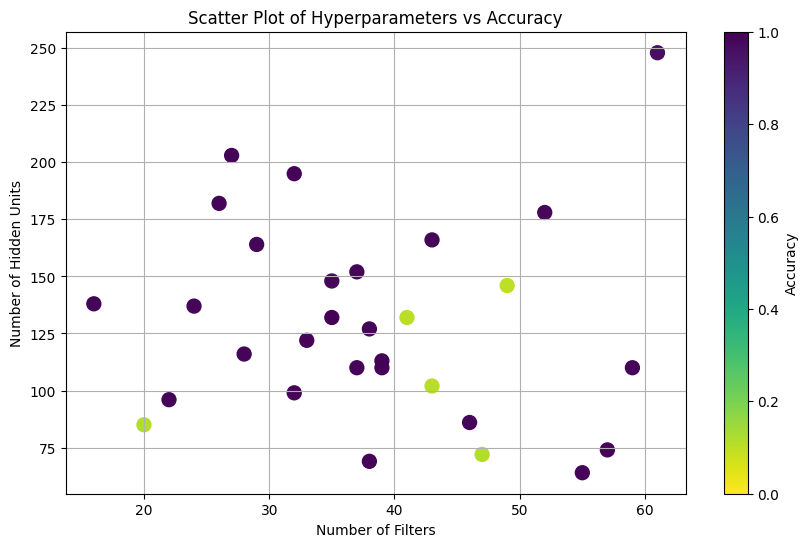

In [25]:
# Запуск Optuna для оптимизации гиперпараметров
if __name__ == "__main__":

    # Глобальные списки для хранения значений
    num_filters_list = []
    hidden_units_list = []
    f1_scores = []

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)

    print("Best trial:")
    trial = study.best_trial

    print("  F1 Score: {}".format(trial.value))  # Получаем F1 Score
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    # Построение графика разброса
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(num_filters_list, hidden_units_list, c=f1_scores, cmap='viridis_r', s=100, vmin=0, vmax=1)
    plt.colorbar(scatter, label='F1 Score')
    plt.xlabel('Number of Filters')
    plt.ylabel('Number of Hidden Units')
    plt.title('Scatter Plot of Hyperparameters vs F1 Score')
    plt.grid(True)
    plt.show()

    # Глобальные списки для хранения значений
    num_filters_list = []
    hidden_units_list = []
    accuracy_list = []

    study = optuna.create_study(direction="maximize")
    study.optimize(objective1, n_trials=30)

    print("Best trial:")
    trial = study.best_trial

    print("  Accuracy: {}".format(trial.value))  # Получаем accuracy
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    # Построение графика точности
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(num_filters_list, hidden_units_list, c=accuracy_list, cmap='viridis_r', s=100, vmin=0, vmax=1)
    plt.colorbar(scatter, label='Accuracy')
    plt.xlabel('Number of Filters')
    plt.ylabel('Number of Hidden Units')
    plt.title('Scatter Plot of Hyperparameters vs Accuracy')
    plt.grid(True)
    plt.show()



Зависимость между количеством фильтров (ядер) и количеством скрытых слоёв не была выявлена